<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/Iteration4_UncertaintyRangeExp_LoanPredict_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Range Experiment
- Dataset : LoanPredict
- Model : RandomForestClassifier
- Reference Dataset : 2010년 (11497, 81)
- Inference Dataset : 2011년 ~ 2018년 (1,323,732, 1)

# 1 구글 드라이브 연결

In [35]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 함수 선언



In [36]:
#@title
# 노이즈를 추가하는 함수 선언
import numpy as np
import random
def random_sample(inp,exp_model_param):
    data_len = len(inp)
    exp_data_len = int(data_len/exp_model_param["split_ratio"])

    if exp_model_param["ramdom_sample_block"] and exp_model_param["split_ratio"]!=1:
        random_index = np.random.randint(0, data_len-exp_data_len)
        random_index = np.arange(random_index, random_index+exp_data_len)
    else:
        random_index = np.random.permutation(data_len)
        random_index = random_index[:exp_data_len]
    return random_index


def random_sigma_add(x_train,x_inf_d,exp_model_param):
    df_state = pd.DataFrame({"mean":np.mean(x_train,axis=0),"std":np.std(x_train,axis=0)})
    permutaion_sigma = random.uniform(exp_model_param["sigma"][0], exp_model_param["sigma"][1])

    #permutation for x_inf_d
    p1 = random.random()
    nums = np.random.choice([0, 1], size=x_inf_d.shape[0], p=[1-p1, p1])
    v = random.choice(range(x_inf_d.shape[1]))

    for v in range(x_inf_d.shape[1]):
        x_inf_d[:,v] = x_inf_d[:,v] + np.random.normal(0, df_state['std'][v]*permutaion_sigma, x_inf_d.shape[0])*nums

    return x_inf_d

def add_drirft_data(exp_model_param,x_train,train_gt ):
    temp_X = []
    temp_Y = []
    for _ in range(exp_model_param["exp_num"][0]):
        sample_idx = random_sample(x_train,exp_model_param)
        temp_X.append(random_sigma_add(x_train,x_train[sample_idx],exp_model_param))
        temp_Y.append(train_gt[sample_idx])
    return temp_X, temp_Y

In [37]:
#@title
# Uncertainty 설정
from scipy.stats import ks_2samp, entropy
def uncertainty_drift_checker(model_type, train, live, evals=100):
    if model_type == "Classification":
        d_value, p_vale = ks_2samp(entropy(train, axis=-1), entropy(live, axis=-1))

    elif model_type == "Regression":
        train_copy = np.concatenate([train for _ in range(evals)], axis=-1)
        test_copy = np.concatenate([live for _ in range(evals)], axis=-1)
        train_std = np.std(train_copy, axis=-1)
        live_std = np.std(test_copy, axis=-1)
        d_value, p_vale = ks_2samp(train_std, live_std)

    return d_value, p_vale

#3 데이터 전처리 및 모델학습

## 3-2 사용할 데이터

In [38]:
#@title
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

#@title
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

#@title
def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value


def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

#4 실험

## 준비

In [39]:
# 실험 모델 환경 설정
import sklearn.metrics as metrics
def acc_fn(y, predict):
    return metrics.accuracy_score(y, predict)*100


def f1_fn(y, predict):
    return metrics.f1_score(y, predict)


In [40]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [224]:
main_figsize = (15,3)

def MI_Drift_F1(model, X,y,train_size,test_size,bucket_size=200):

    MIS = {}
    DRF = {}
    F1S = []
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    step_size = int((X.shape[0]-(train_size+test_size))/bucket_size)

    print('Bucket size',bucket_size,'step_size',step_size)

    for bk in tqdm(range(step_size)):
        #print(bk,step_size)
        tmp_x = X[bk*bucket_size:bk*bucket_size+bucket_size]
        tmp_y = y[bk*bucket_size:bk*bucket_size+bucket_size]
        mi_scores = make_mi_scores(tmp_x,tmp_y , discrete_features="auto")
        ks = __ks_drift(X[0:train_size].values,
                        X[bk*bucket_size+(train_size+test_size):bk*bucket_size+bucket_size+(train_size+test_size)].values)
        predicted_y = model.predict(tmp_x)
        f1_ = metrics.f1_score(tmp_y,(predicted_y > 0.5).astype(float))
        F1S.append(f1_)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    plt.figure(figsize=main_figsize)
    plt.plot(df_mis[columns].values,linewidth=1,label=columns)
    plt.ylabel('MI')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(df_drf[columns].values,linewidth=1,label=columns)
    plt.ylabel('Drift (KS-test)')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1,ncol=5)
    plt.show()

    plt.figure(figsize=main_figsize)
    plt.plot(F1S,linewidth=1,label='f1 score')
    plt.ylabel('F1 Score')
    plt.xlabel(f'bucket ({bucket_size})')
    plt.legend(loc=1)
    plt.show()

In [253]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

class DriftDetector():
    def __init__(self, threshold,n=3):

        self.threshold = threshold
        self.n = n
        self.current_count = 0
        self.time = 0
        self.value = 0.0

    def detect(self, drift_value):
        if self.current_count >= self.n:
            return True

        if self.threshold < drift_value:
            self.current_count = self.current_count +1
        else:
            self.current_count = 0

        self.value = drift_value
        if self.current_count >= self.n:
            return True

        self.time = self.time + 1
        return False

def experiment(X,y,train_size,test_size,live_size,threshold=85):

    seed_everything()

    # Normalize
    scaler_c1 = StandardScaler()
    scaler_c1.fit(X[0:train_size])
    X = pd.DataFrame(scaler_c1.transform(X), columns=columns)
    # Model train...
    model = RandomForestClassifier(max_depth=6).fit(X[0:train_size], y[0:train_size])
    # Dataset 구성
    x_train = X.values[:train_size]
    y_train_gt = y[:train_size].reshape(-1,1)

    x_test = X[test_size:train_size+test_size].values
    y_test_gt = y[test_size:train_size+test_size].reshape(-1,1)

    x_live = X[test_size:].values
    y_live_gt = y[test_size:].reshape(-1,1)

    print('x_train:',x_train.shape, 'x_test:',x_test.shape, 'x_live:',x_live.shape)

    # 기타 parameter 구성
    ######################################### sigma 를 수정
    exp_model_param = {
        "exp_num":[200],#,5000,10000],
        "split_ratio": 1,
        "sigma":[0,1],
        "ramdom_sample_block":True,
        "metric":["acc", "f1"],
        "metric_threshold":[[5,15], [0.05, 0.15]],
        "metric_fn":[acc_fn, f1_fn]
        }

    # 사용할 데이터 및 모델 설정
    predict_fn = model.predict_proba
    model_type = 'Classification'

    # Testset의 Metric 측정
    test_score = []
    # 후미 test_size 개수만 대상.
    y_test = predict_fn(x_test) #[-test_size:])
    print('uncertainty_drift:',y_train_gt.shape,y_test_gt.shape)
    test_unc, _ = uncertainty_drift_checker(model_type, y_train_gt, y_test_gt)

    for i, metric in enumerate(exp_model_param['metric']):
        test_score.append(exp_model_param['metric_fn'][i](y_test_gt, np.argmax(y_test, axis=1).reshape(-1,1)))

    print(f'Metric for Testset : {test_score}, Uncertainty for Testset : {test_unc}',)


    y_train = predict_fn(x_train)
    train_gt = y_train_gt

    # Noise 주입!
    exp_X_list, exp_y_list = add_drirft_data(exp_model_param,x_train,train_gt)
    print('exp_X_list,',np.asarray(exp_X_list).shape)
    result_d_value = []
    result_score = []
    for idx in tqdm(range(len(exp_X_list))):
        exp_y_train = exp_y_list[idx]
        exp_predict = predict_fn(exp_X_list[idx])
        exp_predict_tmp = predict_fn(exp_X_list[idx])

        # 설정한 Metric을 기반으로 Score 계산
        exp_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            if exp_predict_tmp.shape[1] != 1:
                exp_predict_tmp = np.argmax(exp_predict_tmp, axis=1).reshape(-1,1)
            exp_score.append(exp_model_param['metric_fn'][i](exp_y_train, exp_predict_tmp))

        result_score.append(exp_score)

        # Uncertainty Value 계산
        d_value, _ = uncertainty_drift_checker(model_type,y_train, exp_predict)
        result_d_value.append(d_value)

    result_d_value = np.asarray(result_d_value)
    result_score = np.asarray(result_score)
    # 여기서, upper와 lower 를 나눈다.
    result_d_mean_value = []
    result_upper_score = []
    result_lower_score = []
    width = 5
    for n in range(0,exp_model_param['exp_num'][0],width):
        result_d_mean_value.append(np.mean(result_d_value[n:n+width]))
        result_upper_score.append(np.max(result_score[n:n+width,0]))
        result_lower_score.append(np.min(result_score[n:n+width,0]))

    #print(result_upper_score)
    #print(result_lower_score)

    exp_lr_model = LinearRegression().fit(result_d_value.reshape(-1, 1),result_score[:,0])
    exp_up_model = LinearRegression().fit(np.asarray(result_d_mean_value).reshape(-1, 1),result_upper_score)
    exp_lw_model = LinearRegression().fit(np.asarray(result_d_mean_value).reshape(-1, 1),result_lower_score)
    #exp_in_model = LinearRegression().fit(result_score[:,0].reshape(-1, 1),result_d_value)


    ############################# 보정 처리 ############################
    # 실험 LinearRegression의 Y 절편 (drift가 없을 때의 metric) 을 testset의 metric에 맞춤
    # 실험 drift(uncen)의 최소값을 testset의 drift(uncen)에 맞춤
    delta = test_score[0] - exp_lr_model.intercept_
    print('Y Adjustment:',delta)

    delta_x = np.min(result_d_value) - test_unc
    print('X Adjustment:',delta_x )
    ######################################################################
    # real data의 score vs drift 취득
    bucket_size=(train_size,test_size)
    live_set = [x_live[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]] for i in range(int(x_live.shape[0]/bucket_size[1]))]
    live_set_y = [y_live_gt[i*bucket_size[1]:i*bucket_size[1]+bucket_size[0]] for i in range(int(y_live_gt.shape[0]/bucket_size[1]))]

    real_scores = []
    real_d_value = []

    for idx in tqdm(range(len(live_set))):
        predicted_y = predict_fn(live_set[idx])

        # 설정한 Metric을 기반으로 Score 계산
        real_score = []
        for i, metric in enumerate(exp_model_param['metric']):
            if predicted_y.shape[1] != 1:
                predicted_y = np.argmax(predicted_y, axis=1).reshape(-1,1)
            real_score.append(exp_model_param['metric_fn'][i](live_set_y[idx], (predicted_y > 0.5).astype(float)))
        real_scores.append(real_score)

        # Uncertainty Value 계산
        d_value, _ = uncertainty_drift_checker(model_type,live_set_y[idx].reshape(-1,1), predicted_y)
        real_d_value.append(d_value)

    real_d_value = np.asarray(real_d_value)
    real_scores = np.asarray(real_scores)

    real_lr_model = LinearRegression().fit(real_d_value.reshape(-1, 1),real_scores[:,0])
    #real_in_model = LinearRegression().fit(real_scores[:,0].reshape(-1, 1),real_d_value)

    dd = np.concatenate((result_d_value,real_d_value),axis=0)

    d_min = np.min(dd)
    d_max = np.max(dd)
    xsx = np.arange(d_min-(d_max-d_min)/100,d_max,(d_max-d_min)/100)

    plt.scatter(result_d_value,result_score[:,0],marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
    plt.plot(xsx,exp_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_line')

    plt.plot(xsx,exp_up_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_up_line')
    plt.plot(xsx,exp_lw_model.predict(xsx.reshape(-1,1)),linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_) / exp_lr_model.coef_[0]
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f' exp_d_value @ threshold {threshold} : {exp_d_value}')
    print(f'real_d_value @ threshold {threshold} : {rel_d_value}')
    print(f'error @ threshold {threshold} : {np.abs(rel_d_value-exp_d_value)}')

    print("################ 보정 처리 ###############")

    plt.scatter(result_d_value-delta_x,result_score[:,0]+delta,marker='.',linewidth=1,label='exp')
    plt.scatter(real_d_value,real_scores[:,0],marker='.',linewidth=1,label='real')
    plt.plot(xsx-delta_x,exp_lr_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_line')

    plt.plot(xsx-delta_x,exp_up_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_up_line')
    plt.plot(xsx-delta_x,exp_lw_model.predict(xsx.reshape(-1,1))+delta,linewidth=1,label='exp_lw_line')

    plt.plot(xsx,real_lr_model.predict(xsx.reshape(-1,1)),linewidth=1,label='real_line')
    plt.axhline(y = test_score[0], color = 'g', linestyle = ':',label='test_metric')
    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')

    exp_d_value = (threshold - exp_lr_model.intercept_ - delta) / exp_lr_model.coef_[0] - delta_x
    rel_d_value = (threshold - real_lr_model.intercept_) / real_lr_model.coef_[0]
    plt.axvline(x = exp_d_value, color = 'b', linestyle = ':',label='exp d_value')
    plt.axvline(x = rel_d_value, color = 'r', linestyle = ':',label='real d_value')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f' exp_d_value @ threshold {threshold} : {exp_d_value}')
    print(f'real_d_value @ threshold {threshold} : {rel_d_value}')
    print(f'error @ threshold {threshold} : {np.abs(rel_d_value-exp_d_value)}')

    plt.figure(figsize=(15,3))
    predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))+delta
    plt.plot(predict_scores,linewidth=1,label='exp score (adj)')
    # 보정한 결과로 R2 측정
    print(f'r2:{metrics.r2_score(real_scores[:,0],predict_scores)}')
    plt.plot(real_scores[:,0],linewidth=2,label='real score')
    predict_scores = exp_lw_model.predict(real_d_value.reshape(-1,1))
    plt.plot(predict_scores,linewidth=1,linestyle = ':', label='exp score')

    plt.axhline(y = threshold, color = 'r', linestyle = ':',label='threshold')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()





    plt.figure(figsize=(15,3))
    plt.plot(real_d_value,linewidth=1,label='uncen value')
    plt.axhline(y = test_unc, color = 'b', linestyle = ':',label='test_uncen')
    #th1 = test_unc + test_unc * 0.1
    #th2 = test_unc + test_unc * 0.2
    th3 = test_unc + test_unc * 0.3
    #plt.axhline(y = th1, linestyle = ':',label='test_uncen(10%)')
    #plt.axhline(y = th2, linestyle = ':',label='test_uncen(20%)')
    plt.axhline(y = th3, linestyle = ':',color = 'g', label='test_uncen(30%)')

    # test_uncen(30%)을 threshold로 설정, 3회 연속 over일 경우, detect
    ddd = DriftDetector(th3,3)
    dt = [ddd.detect(v) for v in real_d_value]
    if np.sum(dt) > 0:
        plt.axvline(x = ddd.time, color='r', linestyle = ':',label='detect')
        print(f'detect at {ddd.time}time, uncen {ddd.value} metric {real_scores[ddd.time,0]}')

    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    print(f'test_uncen:{test_unc}, uncen threshold:{th3}')



## Case #1 MI의 감소, Drift의 증가

In [150]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

seed_everything()

y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(0,cor_,data_size)

seed_everything(100)

for i in range(400):
    s = i*100
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)


columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
mi_scores = make_mi_scores(X, y, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
x1    0.079411
x0    0.050887
z0    0.027068
Name: MI Scores, dtype: float64


x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [93.27777777777779, 0.9330381848367459], Uncertainty for Testset : 0.0033333333333333335
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:12<00:00, 15.65it/s]


Y Adjustment: -1.0176103743254288
X Adjustment: -0.002777777777777778


100%|██████████| 199/199 [00:06<00:00, 29.60it/s]


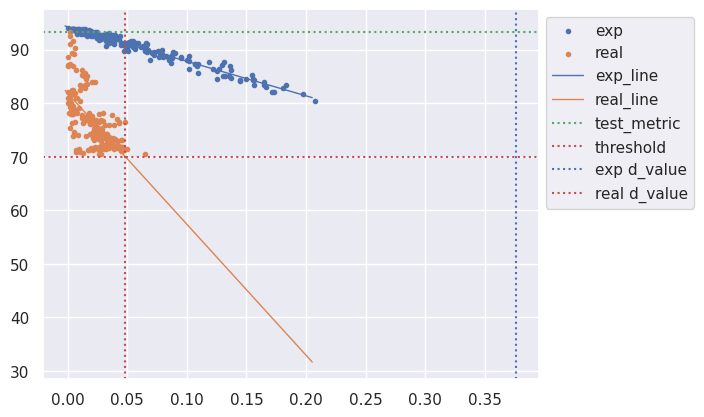

 exp_d_value @ threshold 70 : 0.37607508328021144
real_d_value @ threshold 70 : 0.04846467309931381
error @ threshold 70 : 0.32761041018089765
################ 보정 처리 ###############


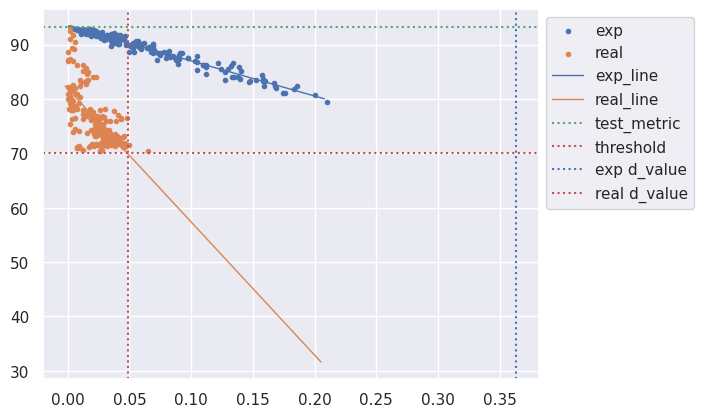

 exp_d_value @ threshold 70 : 0.3631009865098103
real_d_value @ threshold 70 : 0.04846467309931381
error @ threshold 70 : 0.3146363134104965


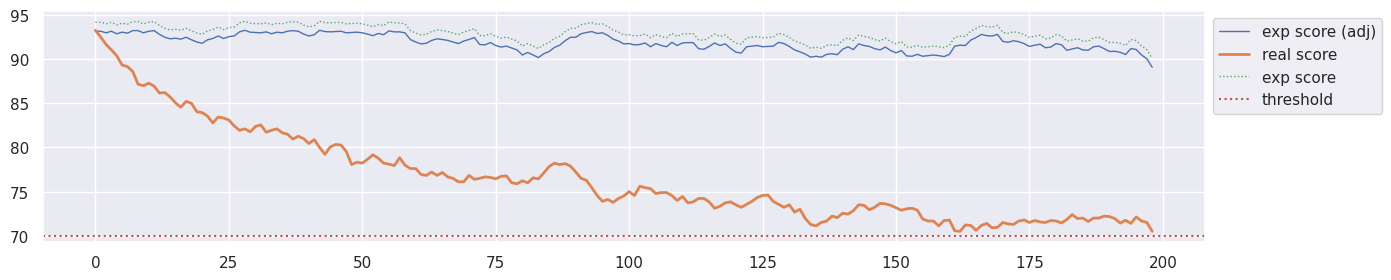

r2:-9.972068147537323
detect at 14time, uncen 0.015 metric 85.72222222222223


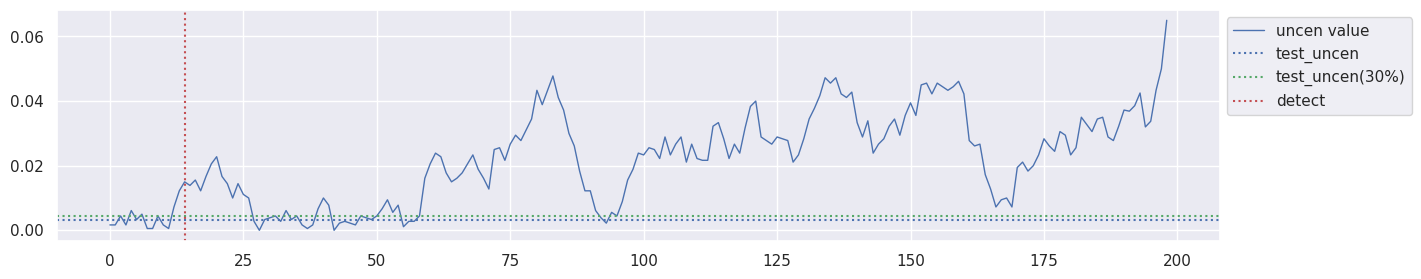

test_uncen:0.0033333333333333335, uncen threshold:0.004333333333333333


In [151]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size,70)

### Case #1 결론
+ test_uncen:0.076
+ 실제 uncen은 모두 0.076 이하로서, 모니터링 못 함!!!

## Case #2 MI의 증감(상대적), Drift의 고정

In [152]:

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)


m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)
mi_scores = make_mi_scores(X1, y1, discrete_features="auto")
print(mi_scores)

5
21426
z0    0.123425
x0    0.079212
x1    0.032962
x2    0.008752
x3    0.007456
Name: MI Scores, dtype: float64


In [153]:
X = X1
y = np.asarray(y1)

x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [94.38888888888889, 0.9522909777987718], Uncertainty for Testset : 0.0016666666666666668
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:13<00:00, 15.04it/s]


Y Adjustment: -1.2870488465031116
X Adjustment: -0.0011111111111111113


100%|██████████| 199/199 [00:06<00:00, 29.22it/s]


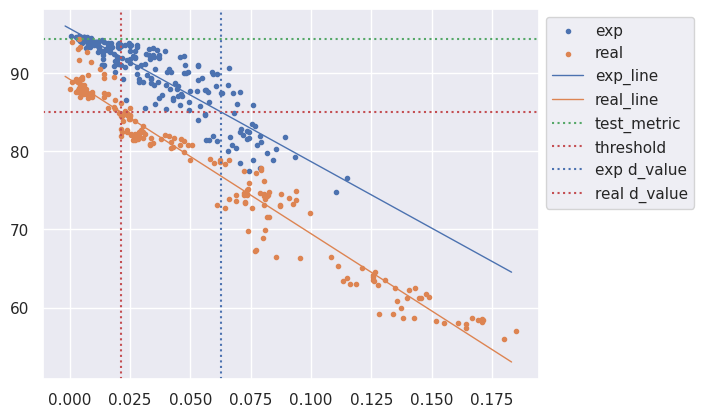

 exp_d_value @ threshold 85 : 0.0627660398570021
real_d_value @ threshold 85 : 0.021219891330906494
error @ threshold 85 : 0.04154614852609561
################ 보정 처리 ###############


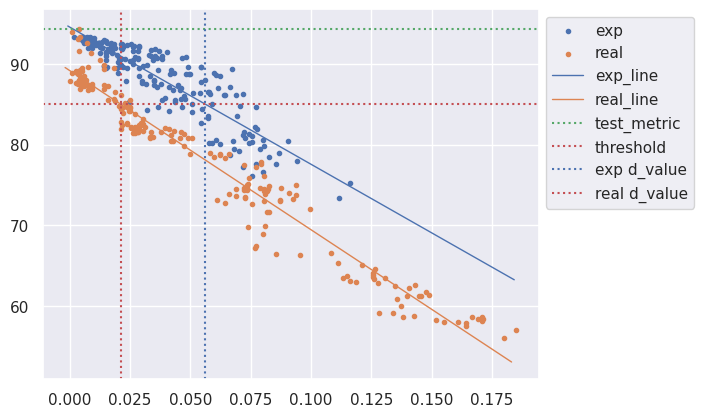

 exp_d_value @ threshold 85 : 0.05631032534588072
real_d_value @ threshold 85 : 0.021219891330906494
error @ threshold 85 : 0.03509043401497423


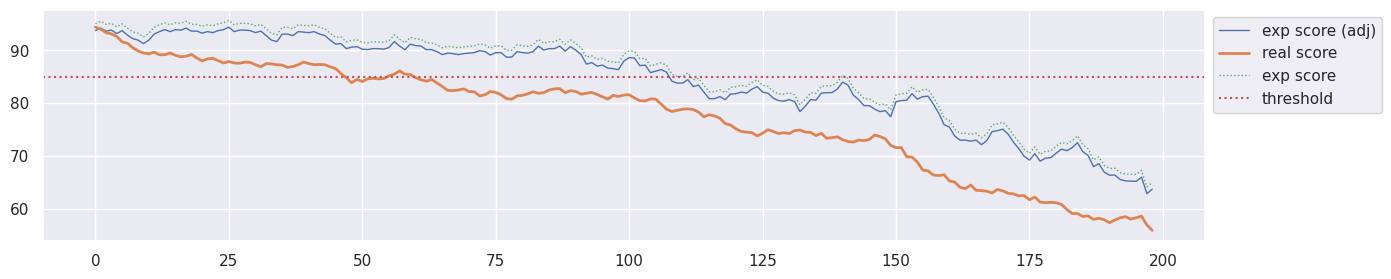

r2:0.28692948271355323
detect at 4time, uncen 0.007222222222222222 metric 92.61111111111111


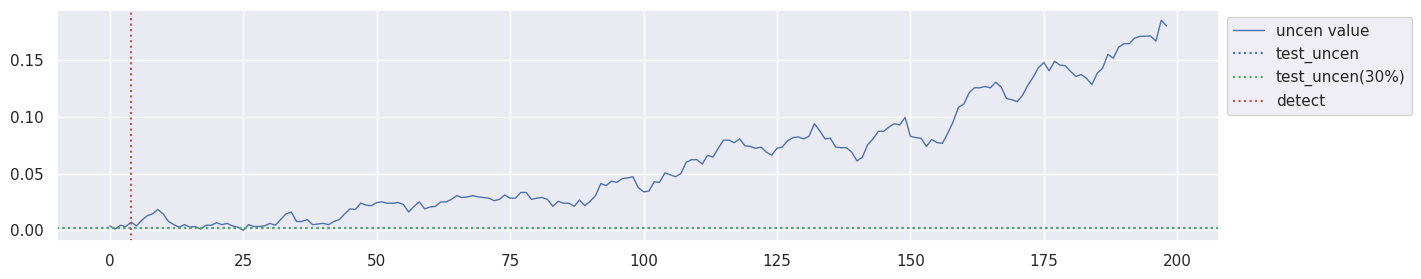

test_uncen:0.0016666666666666668, uncen threshold:0.0021666666666666666


In [154]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size)

### Case #2 결론
+ test_uncen:0.022
+ threshold 를 2회 넘는 경우를 탐지로 볼 경우, 약 10 Time에 탐지.
+ 이때의 metric은 90 -> 85 수준,

## Case #3 MI의 증감(상대적), Drift의 증가

In [155]:

seed_everything(2)

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

x2 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x2[:,ix] = np.random.normal(1,cor_,data_size)

y2_array = []
cor_const = 3/x2.shape[0]
for ii in range(x2.shape[0]):
    e = np.random.normal(0.0+10*ii/40000, 5*cor_const * ii)
    e1 = 0.0 #np.random.normal(0.0, cor_const * ii)
    x2[ii,4] = x2[ii,4] + e
    y2_array.append(np.sum(cor * x2[ii])+e1)

m = np.mean(y2_array)
print(m)
y2 = [1 if y_ > m else 0 for y_ in y2_array]
sum(y2)

columns=['x0','x1','x2','x3','z0']
X2 = pd.DataFrame(x2,columns=columns)
mi_scores = make_mi_scores(X2, y2, discrete_features="auto")
print(mi_scores)

7.2404412558678075
z0    0.269203
x0    0.077964
x1    0.028502
x2    0.012955
x3    0.001920
Name: MI Scores, dtype: float64


In [156]:
X = X2
y = np.asarray(y2)

x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [97.94444444444444, 0.9456681350954479], Uncertainty for Testset : 0.0038888888888888888
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:12<00:00, 16.29it/s]


Y Adjustment: -1.4857273536402715
X Adjustment: -0.003333333333333333


100%|██████████| 199/199 [00:06<00:00, 29.68it/s]


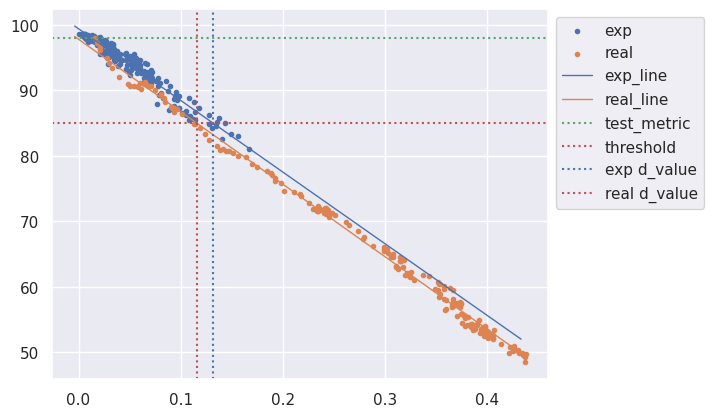

 exp_d_value @ threshold 85 : 0.13183540240706662
real_d_value @ threshold 85 : 0.1158412168415183
error @ threshold 85 : 0.015994185565548324
################ 보정 처리 ###############


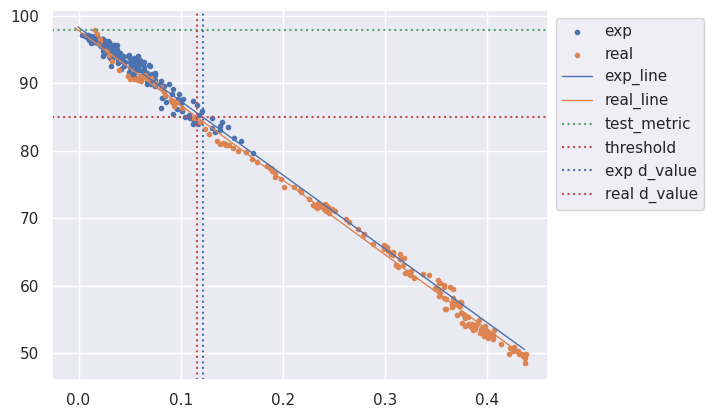

 exp_d_value @ threshold 85 : 0.12159499134739493
real_d_value @ threshold 85 : 0.1158412168415183
error @ threshold 85 : 0.005753774505876635


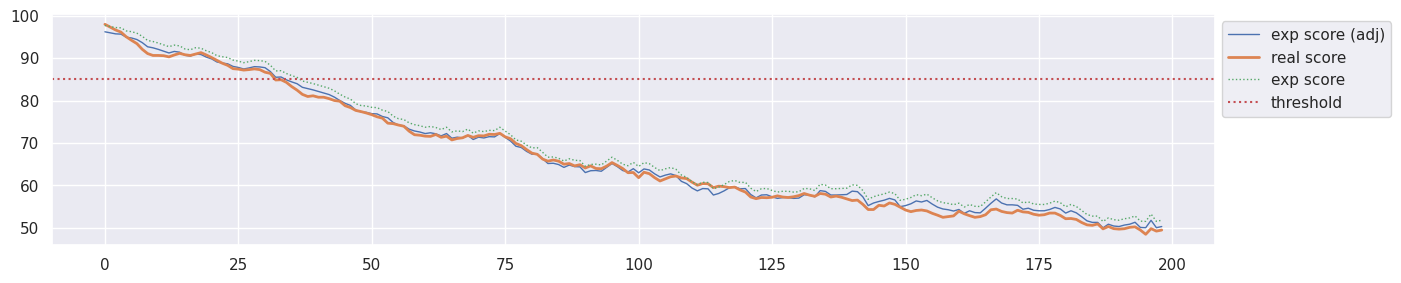

r2:0.9757599698207724
detect at 2time, uncen 0.020555555555555556 metric 96.61111111111111


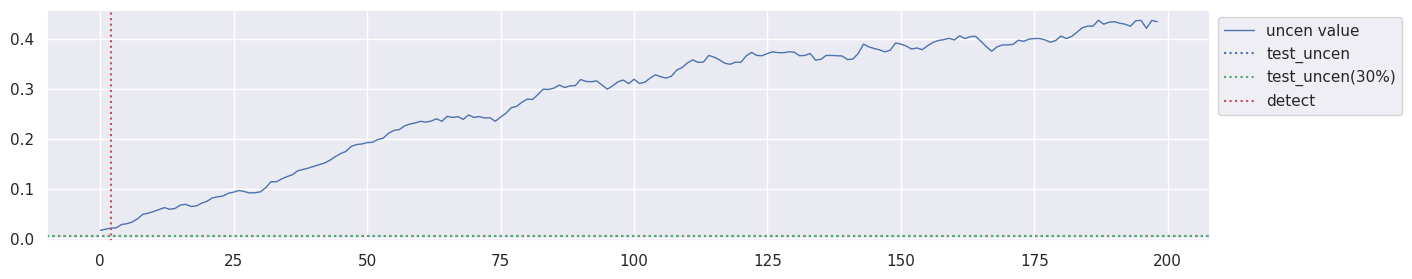

test_uncen:0.0038888888888888888, uncen threshold:0.005055555555555555


In [157]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size)

### Case #3 결론
+ test_uncen:0.0088
+ 탐지 못 함.

## Case #4 MI의 고정, Drift의 증가

In [158]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)

columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)
mi_scores = make_mi_scores(X3, y3, discrete_features="auto")
print(mi_scores)

x3    0.202783
x2    0.134082
z0    0.091439
x1    0.079411
x0    0.050887
Name: MI Scores, dtype: float64


In [159]:
X = X3
y = np.asarray(y3)

x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [95.77777777777777, 0.9584699453551913], Uncertainty for Testset : 0.0033333333333333335
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:12<00:00, 15.46it/s]


Y Adjustment: -1.134689716117208
X Adjustment: -0.002777777777777778


100%|██████████| 199/199 [00:06<00:00, 31.62it/s]


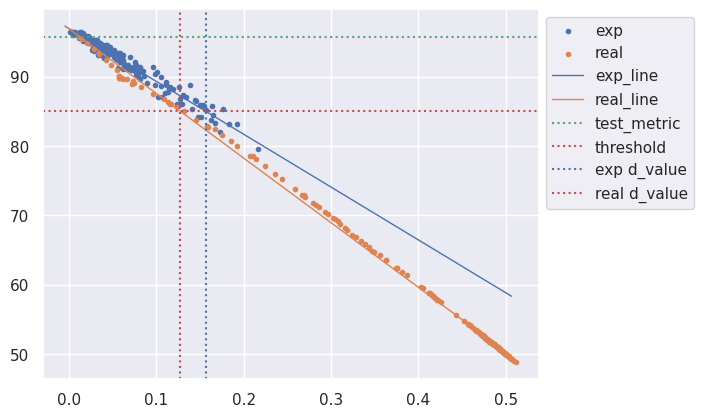

 exp_d_value @ threshold 85 : 0.15633942178976637
real_d_value @ threshold 85 : 0.1273614903538888
error @ threshold 85 : 0.02897793143587757
################ 보정 처리 ###############


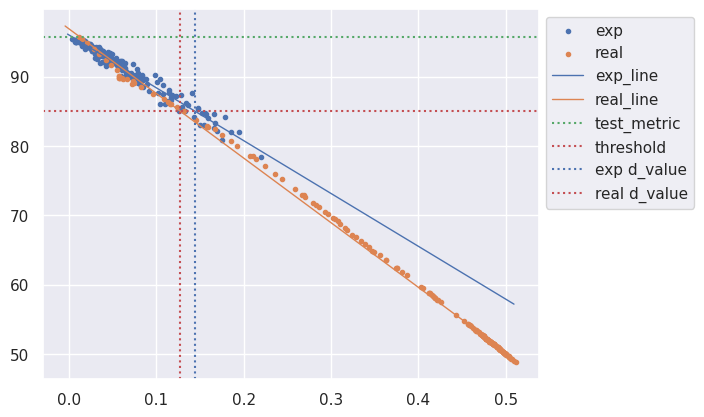

 exp_d_value @ threshold 85 : 0.1442255128351797
real_d_value @ threshold 85 : 0.1273614903538888
error @ threshold 85 : 0.016864022481290902


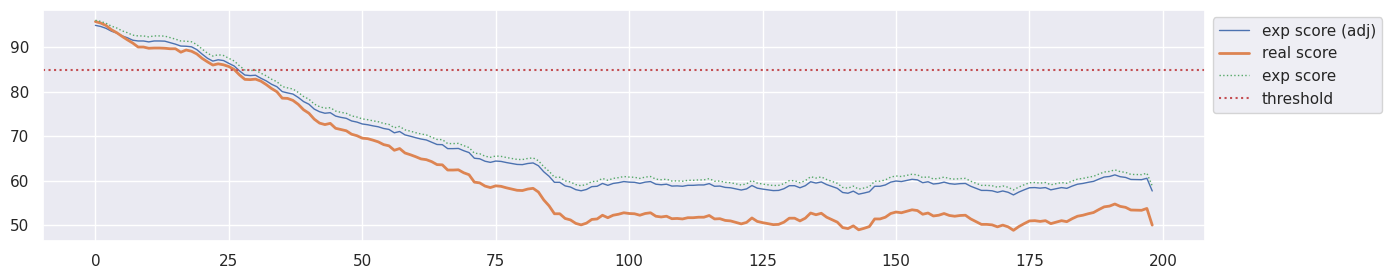

r2:0.7563817910164443
detect at 2time, uncen 0.02 metric 94.88888888888889


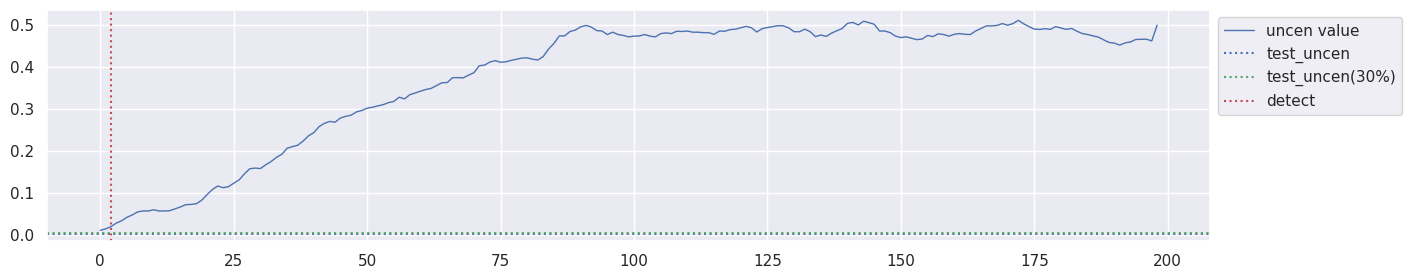

test_uncen:0.0033333333333333335, uncen threshold:0.004333333333333333


In [160]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size)

### Case #4 결론
+ test_uncen:0.076
+ 2회 threshold 오버의 경우, 약 8 Time이 탐지
+ 이때 metric은 90 -> 85 수준

## Case #5 Case #1,2,3,4의 상황이 각 feature에 혼재되어 있는 경우

In [180]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    # Case #2, MI의 증감(상대적), Drift의 고정 - z0
    cor[4] = cor[4] - cor_const / x4.shape[0]
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #1 MI의 감소, Drift의 증가 - x2
    x4[i,2] = y4[i] + np.random.normal(1,0.5+(i/data_size))
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

x3    0.145527
x2    0.113997
z0    0.092832
x0    0.043090
x1    0.024980
Name: MI Scores, dtype: float64


In [181]:
X = X4
y = np.asarray(y4)

x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [96.77777777777777, 0.9727187206020697], Uncertainty for Testset : 0.0033333333333333335
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:12<00:00, 15.72it/s]


Y Adjustment: -0.8560234243099814
X Adjustment: -0.002777777777777778


100%|██████████| 199/199 [00:06<00:00, 29.67it/s]


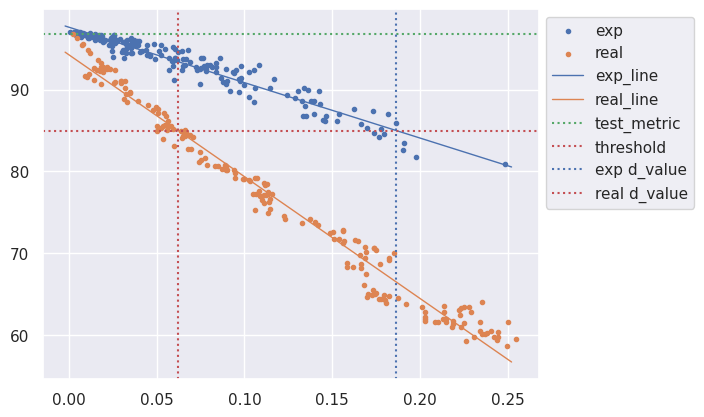

 exp_d_value @ threshold 85 : 0.18630430529234382
real_d_value @ threshold 85 : 0.06223011685284594
error @ threshold 85 : 0.12407418843949788
################ 보정 처리 ###############


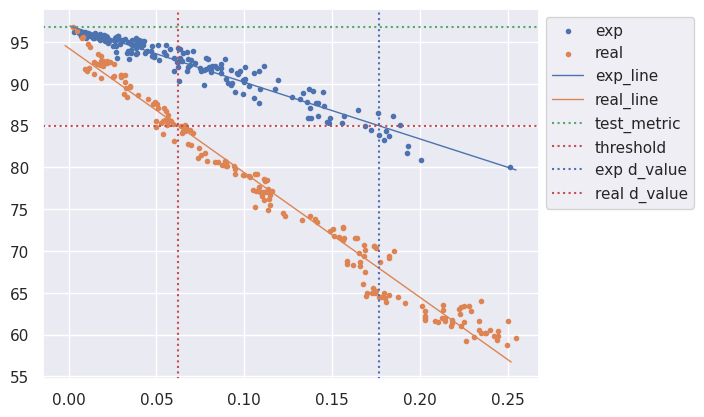

 exp_d_value @ threshold 85 : 0.17645873663392075
real_d_value @ threshold 85 : 0.06223011685284594
error @ threshold 85 : 0.11422861978107482


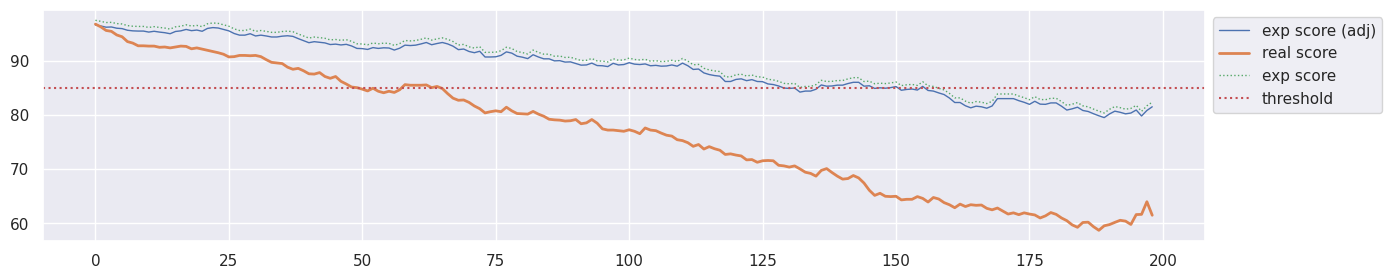

r2:-0.6785547661804952
detect at 3time, uncen 0.0077777777777777776 metric 95.44444444444444


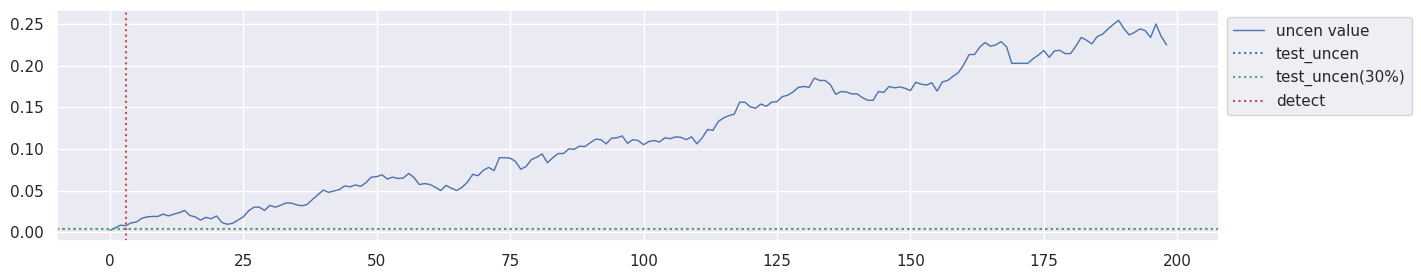

test_uncen:0.0033333333333333335, uncen threshold:0.004333333333333333


In [182]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size)

### Case #5 결론
+ test_uncen:0.0022
+ 처음부터 over, 탐지 안됨

## Case #6 Case #3,4의 상황이 각 feature에 혼재되어 있는 경우

In [183]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.5 , 0.7, 2.5])

x4 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x4[:,ix] = np.random.normal(1,cor_,data_size)

y4_array = []
cor_const = cor[4]
cor_const2 = 3/x4.shape[0]
for ii in range(x4.shape[0]):
    e = np.random.normal(0.0, 2.0)
    # Case #3 MI의 증감(상대적), Drift의 증가 - x3
    e1 = np.random.normal(0.0, 3*cor_const2 * ii)
    x4[ii,3] = x4[ii,3] + e1
    y4_array.append(np.sum(cor * x4[ii])+e)

y4 = [1 if y_ > 5 else 0 for y_ in y4_array]

for i in range(len(y4)):
    #Case #4 MI의 고정, Drift의 증가 - x1
    x4[i,1] = y4[i] + np.random.normal(0.0 + 4*(i/data_size),cor[1])


columns=['x0','x1','x2','x3','z0']
X4 = pd.DataFrame(x4,columns=columns)
mi_scores = make_mi_scores(X4, y4, discrete_features="auto")
print(mi_scores)

z0    0.254714
x3    0.067504
x1    0.043212
x0    0.026915
x2    0.001097
Name: MI Scores, dtype: float64


In [184]:
X = X4
y = np.asarray(y4)

x_train: (1800, 5) x_test: (1800, 5) x_live: (39800, 5)
uncertainty_drift: (1800, 1) (1800, 1)
Metric for Testset : [92.72222222222221, 0.9392111368909513], Uncertainty for Testset : 0.0033333333333333335
exp_X_list, (200, 1800, 5)


100%|██████████| 200/200 [00:12<00:00, 15.47it/s]


Y Adjustment: -1.7407312852876515
X Adjustment: -0.002777777777777778


100%|██████████| 199/199 [00:06<00:00, 29.70it/s]


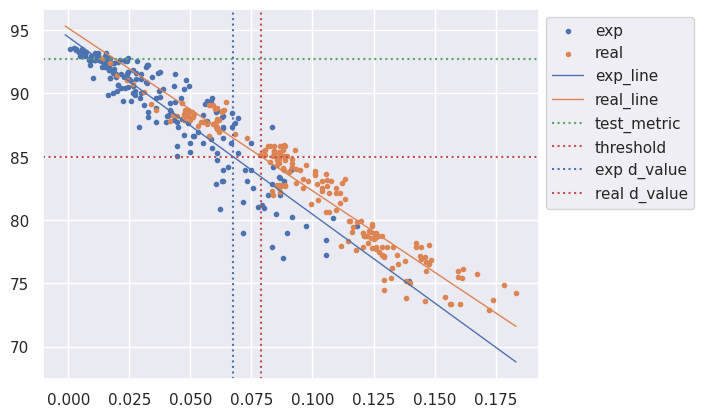

 exp_d_value @ threshold 85 : 0.0675659268717485
real_d_value @ threshold 85 : 0.07908299658768217
error @ threshold 85 : 0.011517069715933664
################ 보정 처리 ###############


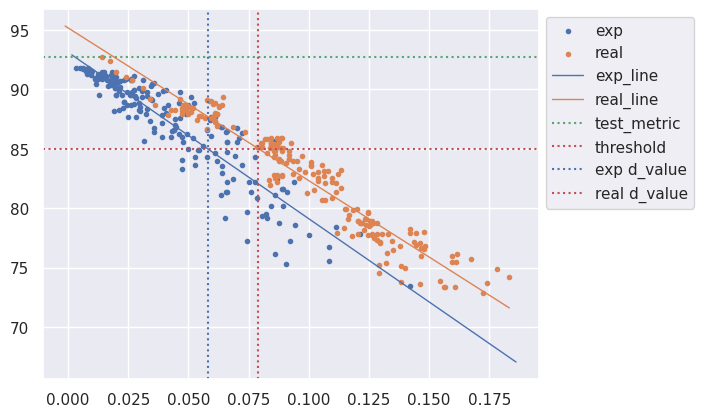

 exp_d_value @ threshold 85 : 0.05791480254916503
real_d_value @ threshold 85 : 0.07908299658768217
error @ threshold 85 : 0.021168194038517142


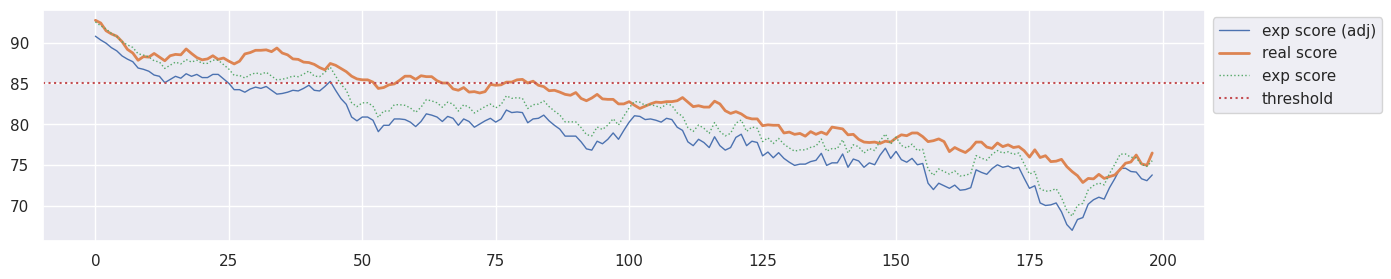

r2:0.768987049071731
detect at 2time, uncen 0.02 metric 91.44444444444444


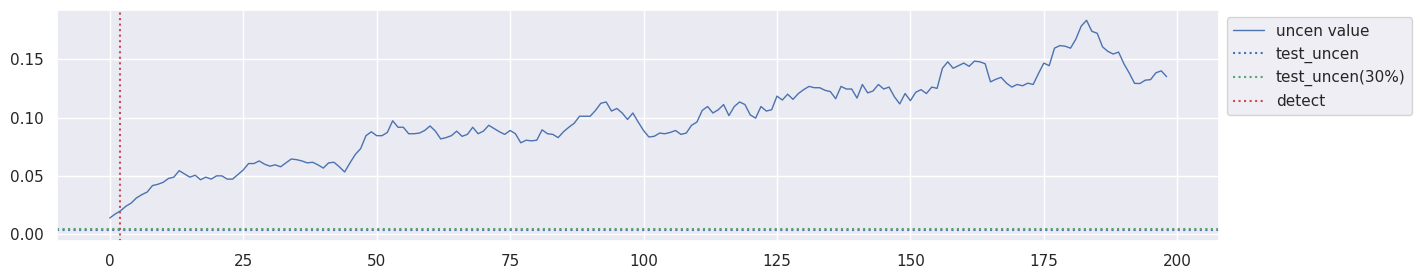

test_uncen:0.0033333333333333335, uncen threshold:0.004333333333333333


In [185]:
train_size = 1800
test_size = 200
live_size = 400

experiment(X,y,train_size,test_size,live_size)

## Real-world data(Loan data)의 실험

In [186]:
df_accepted = pd.read_csv("/content/drive/MyDrive/Drift/accepted_2007_to_2018Q4.csv")

print(df_accepted.shape)

(2260701, 151)


In [187]:
# for the sake of simplicity, let's consider only Fully Paid and Charged Off values:
df_accepted = df_accepted[df_accepted.loan_status.isin(['Fully Paid', 'Charged Off'])]
print(df_accepted.shape)

cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(50).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# maybe we can go further, and eliminate columns up to title:
cols_to_drop = df_accepted.isnull().sum().sort_values(ascending=False).head(45).index
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# Remaining columns have missing data points, but they account for less than 0.2% of the total data. Let's remove the rows that are missing those values in those columns with dropna():
df_accepted = df_accepted.dropna()
print(df_accepted.shape)

# These are constant columns. We can drop it either.
cols_to_drop = ['out_prncp', 'out_prncp_inv', 'policy_code']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

# It seems we have many "duplicated" information. Let's drop some columns, based on visual inspection at corr_pairs dataframe:
cols_to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)

values = df_accepted.loan_status.unique()
encode = [1,0]
d = dict(zip(values, encode))
df_accepted['loan_paid'] = df_accepted['loan_status'].map(d)
df_accepted = df_accepted.drop(columns=['loan_status'])

df_accepted


(1345310, 151)
(1345310, 101)
(1345310, 56)
(1341026, 56)
(1341026, 53)
(1341026, 44)


,id,loan_amnt,term,int_rate,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,hardship_flag,disbursement_method,debt_settlement_flag,loan_paid
0,68407277,3600.0,36 months,13.99,C,C4,MORTGAGE,55000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
1,68355089,24700.0,36 months,11.99,C,C1,MORTGAGE,65000.0,Not Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2,68341763,20000.0,60 months,10.78,B,B4,MORTGAGE,63000.0,Not Verified,Dec-2015,...,Joint App,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
4,68476807,10400.0,60 months,22.45,F,F1,MORTGAGE,104433.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
5,68426831,11950.0,36 months,13.44,C,C3,RENT,34000.0,Source Verified,Dec-2015,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,89905081,18000.0,60 months,9.49,B,B2,OWN,130000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260690,88948836,29400.0,60 months,13.99,C,C3,MORTGAGE,180792.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,1
2260691,89996426,32000.0,60 months,14.49,C,C4,MORTGAGE,157000.0,Source Verified,Oct-2016,...,Individual,0.0,0.0,0.0,0.0,0.0,N,Cash,N,0
2260692,90006534,16000.0,60 months,12.79,C,C1,RENT,150000.0,Not Verified,Oct-2016,...,Individual,0.0,0.0,0.0,3.0,0.0,N,Cash,N,1


In [188]:
# droping constant columns
print(df_accepted.pymnt_plan.value_counts())
print(df_accepted.hardship_flag.value_counts())
cols_to_drop = ['id', 'pymnt_plan', 'hardship_flag']
df_accepted = df_accepted.drop(columns=cols_to_drop)
print(df_accepted.shape)
cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

print(df_accepted.term.value_counts())

# convert term into either a 36 or 60 integer numeric data type

l1 = df_accepted.term.unique()
l2 = [36, 60]
d = dict(zip(l1, l2))

df_accepted['term'] = df_accepted['term'].map(d)

# as grade is part of sub_grade, so let's just drop the grade feature.

df_accepted = df_accepted.drop(columns='grade')

df_accepted = pd.get_dummies(df_accepted, columns = ['sub_grade'], prefix='', prefix_sep='', drop_first=True)

cat_cols = df_accepted.select_dtypes(include=['object']).columns
print(cat_cols)

# for these columns, let's just create dummy variables, concatenate them with the original dataframe and drop original columns.

df_accepted = pd.get_dummies(df_accepted, columns = ['verification_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['application_type'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['initial_list_status'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['purpose'], prefix='', prefix_sep='', drop_first=True)
print(df_accepted.shape)

df_accepted['home_ownership'] = df_accepted.home_ownership.replace('NONE', 'ANY')
df_accepted = pd.get_dummies(df_accepted, columns = ['home_ownership'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=[ 'url', 'last_pymnt_d', 'last_credit_pull_d'])
df_accepted = df_accepted.drop(columns=['zip_code', 'addr_state'])
df_accepted = pd.get_dummies(df_accepted, columns = ['disbursement_method'], prefix='', prefix_sep='', drop_first=True)
df_accepted = pd.get_dummies(df_accepted, columns = ['debt_settlement_flag'], prefix='', prefix_sep='', drop_first=True)
df_accepted = df_accepted.drop(columns=['earliest_cr_line'])
print(df_accepted.shape)


df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jan','01')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Feb','02')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Mar','03')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Apr','04')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('May','05')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jun','06')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Jul','07')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Aug','08')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Sep','09')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Oct','10')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Dec','11')
df_accepted['issue_d'] = df_accepted['issue_d'].str.replace('Nov','12')

def reorder_issue_d(dt):
    a = dt.split('-')
    return a[1]+a[0]

reorder_issue_d('01-2009')

df_accepted['issue_d'] = df_accepted['issue_d'].apply(reorder_issue_d)
df_accepted = df_accepted.sort_values(by='issue_d')
df_accepted.reset_index(drop=True, inplace=True)

df_accepted.info()

n    1341026
Name: pymnt_plan, dtype: int64
N    1341026
Name: hardship_flag, dtype: int64
(1341026, 41)
Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'url', 'purpose', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'disbursement_method',
       'debt_settlement_flag'],
      dtype='object')
 36 months    1017398
 60 months     323628
Name: term, dtype: int64
Index(['home_ownership', 'verification_status', 'issue_d', 'url', 'purpose',
       'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
       'last_pymnt_d', 'last_credit_pull_d', 'application_type',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')
(1341026, 86)
(1341026, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1341026 entries, 0 to 1341025
Data columns (total 83 columns):
 #   Column                      Non-Null Count    Dtype  

In [201]:

X = {}
Y = {}

df = df_accepted[df_accepted['issue_d'].str.startswith('2007') + df_accepted['issue_d'].str.startswith('2008') + df_accepted['issue_d'].str.startswith('2009')].copy()
df = df_accepted.drop(columns=['issue_d'])


X[2009] = df.loc[:, df.columns != 'loan_paid'].values
Y[2009] = df.loan_paid.values


for year in range(2010,2019):
    print(year)
    df = df_accepted[df_accepted['issue_d'].str.startswith(str(year))].copy()
    df = df.drop(columns=['issue_d'])
    X[year] = df.loc[:, df.columns != 'loan_paid'].values
    Y[year] = df.loan_paid.values

2010
2011
2012
2013
2014
2015
2016
2017
2018


In [202]:

COLUMNS = df.loc[:, df.columns != 'loan_paid'].columns
COLUMNS

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'last_pymnt_amnt', 'last_fico_range_high',
       'collections_12_mths_ex_med', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3',
       'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5',
       'Source Verified', 'Verified', 'Joint App', 'w', 'credit_card',
       'debt_consolidation', 'educational', 'home_improvement', 'house',
       'major_purchase', 'medical', 'moving', 'other', 'renewable_energy',
       'small_business', 'vacation', 'wedding', 'MORTGAGE', 'OTHER', 'OWN',
       'RENT', 'DirectPay', 'Y'],
      dtype

In [203]:
X_df = pd.DataFrame(X[2010],columns=COLUMNS)
mi_scores = make_mi_scores(X_df, Y[2010], discrete_features="auto")
print(mi_scores)

recoveries              0.375383
last_fico_range_high    0.093120
last_pymnt_amnt         0.085917
total_rec_late_fee      0.035926
int_rate                0.018717
                          ...   
G3                      0.000000
G4                      0.000000
G5                      0.000000
Verified                0.000000
loan_amnt               0.000000
Name: MI Scores, Length: 81, dtype: float64


In [204]:

# MI Top 5, columns
top_columns = list(mi_scores[0:5].index)
top_columns

['recoveries',
 'last_fico_range_high',
 'last_pymnt_amnt',
 'total_rec_late_fee',
 'int_rate']

In [255]:
top_columns = list(mi_scores[1:5].index)
top_columns

['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate']

In [256]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[17, 16, 14, 2]

In [257]:

# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


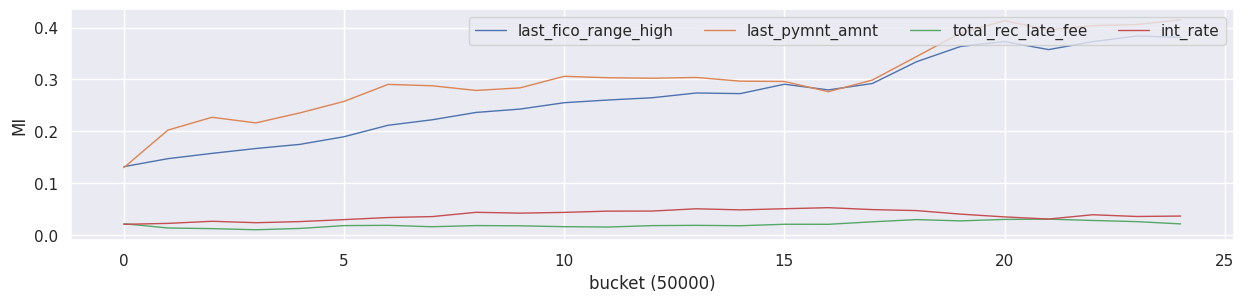

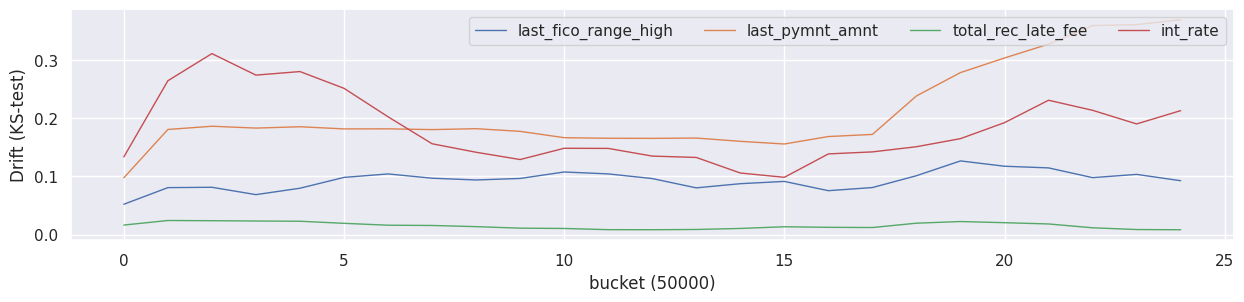

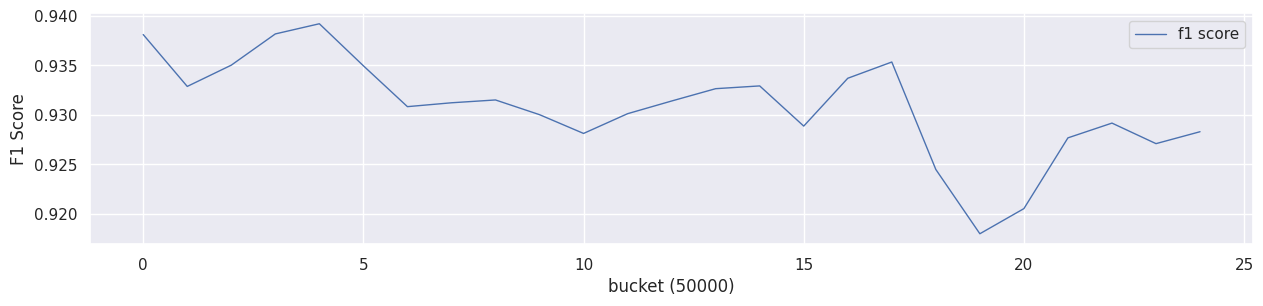

In [258]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

In [259]:
Xr = X2
yr = np.asarray(Y2)

x_train: (10000, 4) x_test: (10000, 4) x_live: (1278533, 4)
uncertainty_drift: (10000, 1) (10000, 1)
Metric for Testset : [90.42999999999999, 0.9468185607113088], Uncertainty for Testset : 0.0012
exp_X_list, (200, 10000, 4)


100%|██████████| 200/200 [00:40<00:00,  4.94it/s]


Y Adjustment: 0.2659136860885951
X Adjustment: 0.00030000000000000014


100%|██████████| 1114/1114 [01:57<00:00,  9.46it/s]


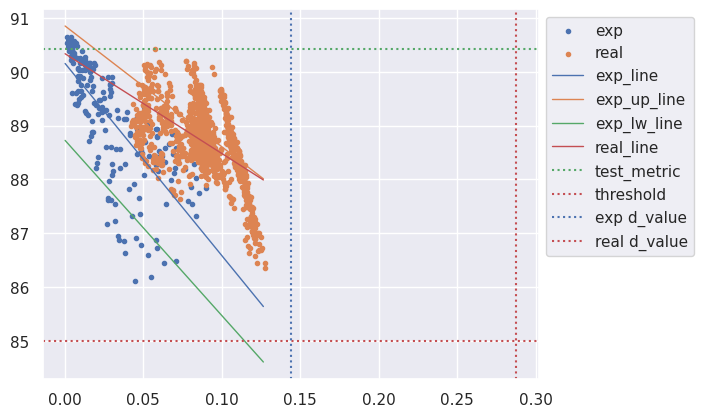

 exp_d_value @ threshold 85 : 0.14434828636366367
real_d_value @ threshold 85 : 0.28749453469590397
error @ threshold 85 : 0.1431462483322403
################ 보정 처리 ###############


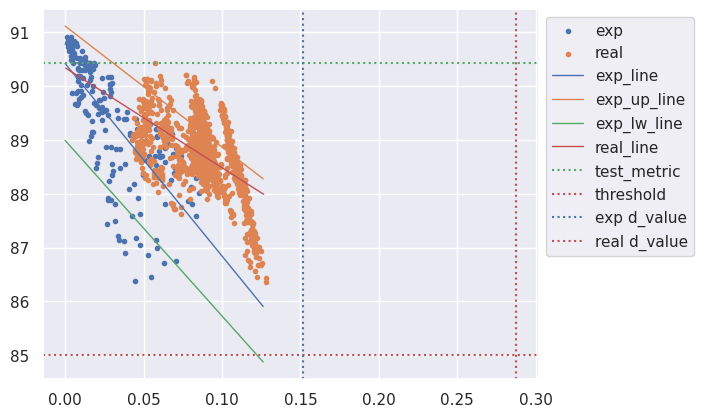

 exp_d_value @ threshold 85 : 0.15148119560922216
real_d_value @ threshold 85 : 0.28749453469590397
error @ threshold 85 : 0.1360133390866818
r2:-14.902579320323579


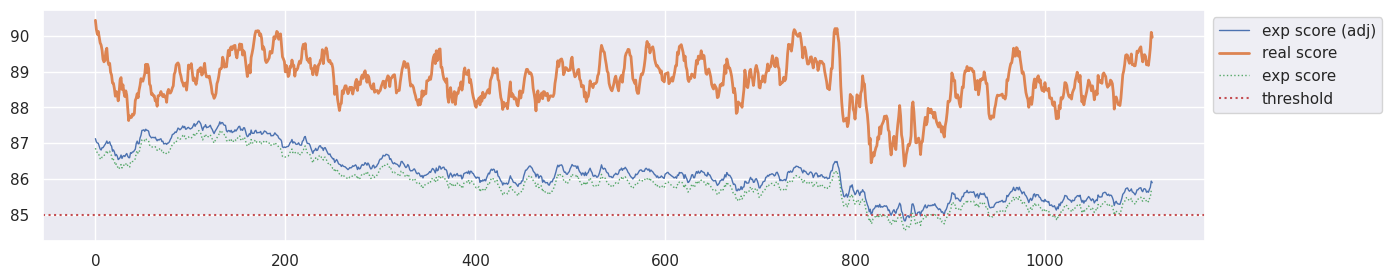

detect at 2time, uncen 0.0612 metric 90.03999999999999


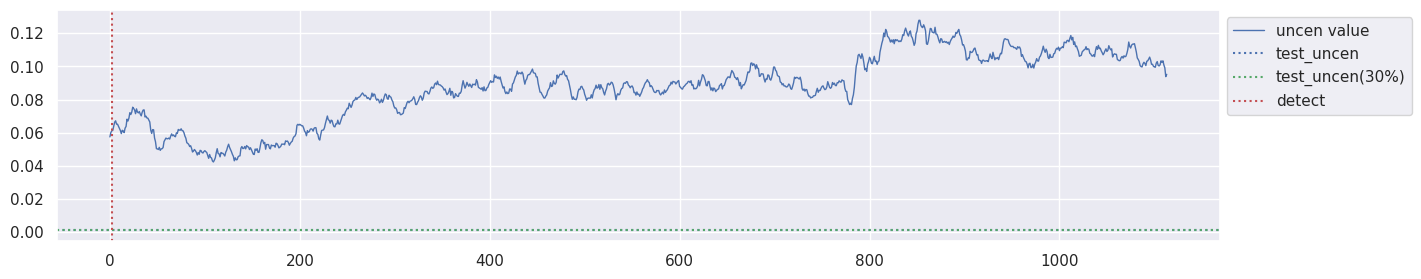

test_uncen:0.0012, uncen threshold:0.0015599999999999998


In [260]:
train_size = 10000
test_size = 1147
live_size = 50000
columns = top_columns
experiment(Xr,yr,train_size,test_size,live_size)

In [238]:
top_columns = list(mi_scores[3:5].index)
top_columns

['total_rec_late_fee', 'int_rate']

In [239]:
top_columns_index = [list(COLUMNS).index(tc) for tc in top_columns]
top_columns_index

[14, 2]

In [240]:
# 사용할 5개의 feature만 추림... ['last_fico_range_high', 'last_pymnt_amnt', 'total_rec_late_fee', 'int_rate', 'term']
X2 = np.concatenate((X[2010],X[2011],X[2012],X[2013],X[2014],X[2015],X[2016],X[2017]))
Y2 = np.concatenate((Y[2010],Y[2011],Y[2012],Y[2013],Y[2014],Y[2015],Y[2016],Y[2017]))
X2 = pd.DataFrame(X2,columns = COLUMNS)
X2 = X2[top_columns]

Bucket size 50000 step_size 25


100%|██████████| 25/25 [00:20<00:00,  1.19it/s]


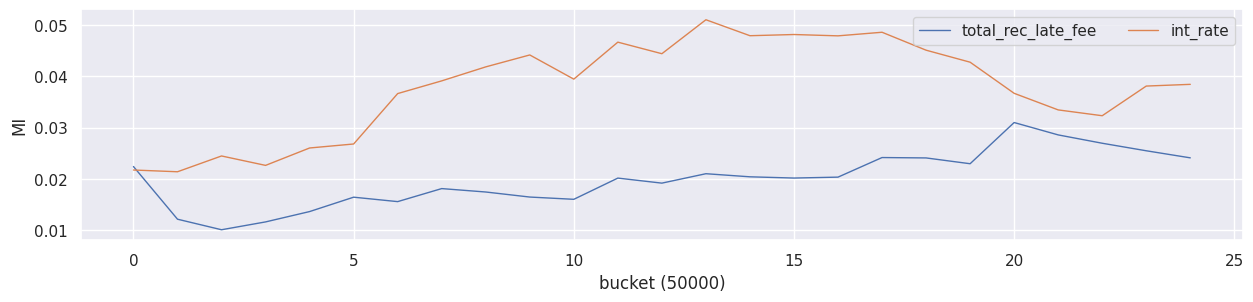

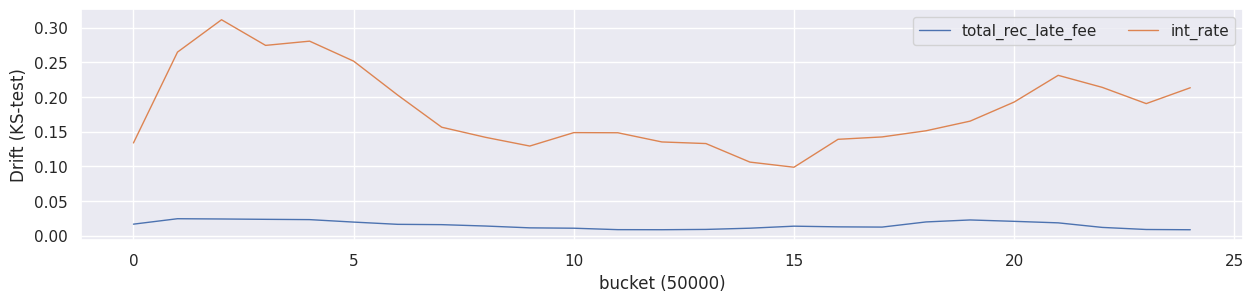

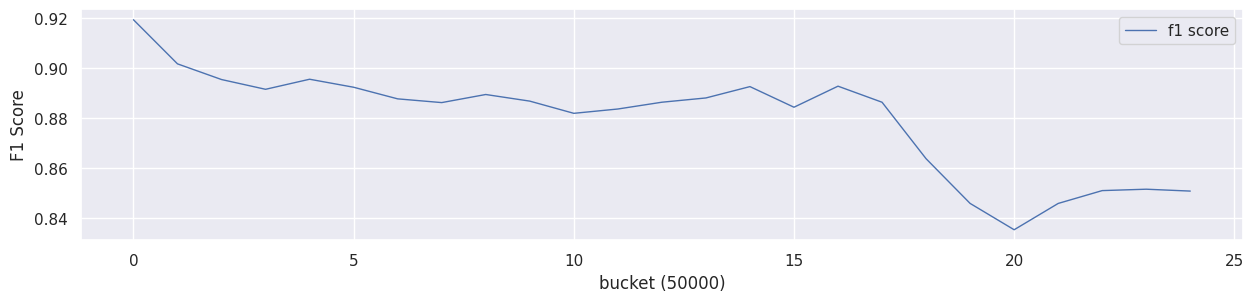

In [241]:
model = RandomForestClassifier(max_depth=6).fit(X2[0:10000].values, Y2[0:10000])

columns = top_columns
MI_Drift_F1(model, X2,Y2,10000,1147,50000)

x_train: (10000, 2) x_test: (10000, 2) x_live: (1278533, 2)
uncertainty_drift: (10000, 1) (10000, 1)
Metric for Testset : [88.3, 0.9370222844224352], Uncertainty for Testset : 0.0012
exp_X_list, (200, 10000, 2)


100%|██████████| 200/200 [00:40<00:00,  4.95it/s]


Y Adjustment: 0.19634124729324753
X Adjustment: 0.0011


100%|██████████| 1114/1114 [01:59<00:00,  9.31it/s]


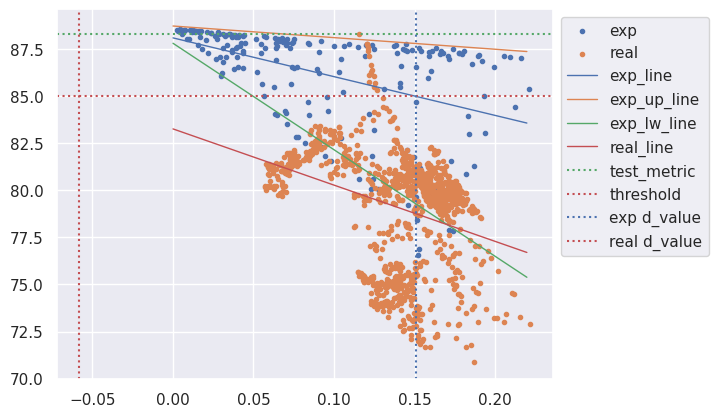

 exp_d_value @ threshold 85 : 0.15063114082577905
real_d_value @ threshold 85 : -0.057944045415874106
error @ threshold 85 : 0.20857518624165317
################ 보정 처리 ###############


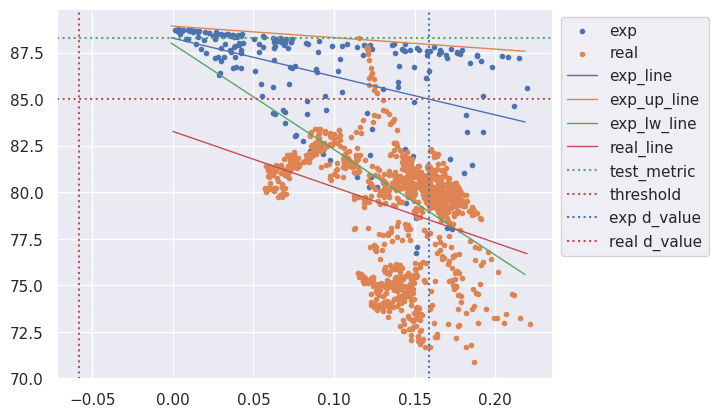

 exp_d_value @ threshold 85 : 0.15906025095914839
real_d_value @ threshold 85 : -0.057944045415874106
error @ threshold 85 : 0.2170042963750225
r2:-0.08413653418630251


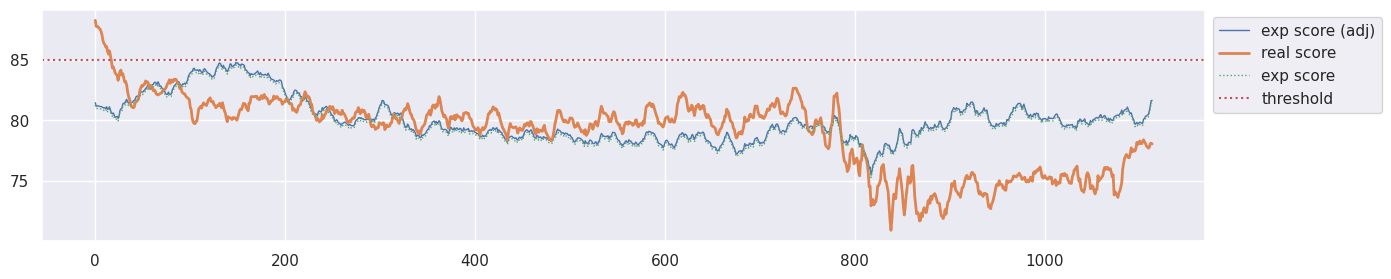

detect at 2time, uncen 0.1207 metric 87.77000000000001


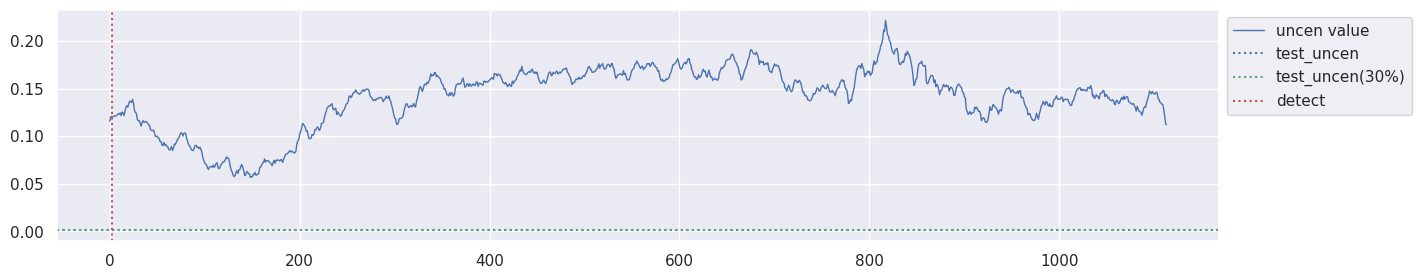

test_uncen:0.0012, uncen threshold:0.0015599999999999998


In [254]:
Xr = X2
yr = np.asarray(Y2)

train_size = 10000
test_size = 1147
live_size = 50000
columns = top_columns
experiment(Xr,yr,train_size,test_size,live_size)

### Case Loan data 결론
+ test_uncen:0.0092
+ 처음부터 over 됨.